In [335]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
#from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader, random_split
from collections import OrderedDict
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re # search in an string

In [336]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [337]:
def determine_wind_and_leak(file_path):
    leak_s = None
    wind = None
    leak_x = None
    leak_y = None
    file_name = file_path[-8:]

    radius = 40
    # determine free-stream ambient wind speed
    if re.search(r'l[hl]', file_name):
        wind = 6
    elif re.search(r'm[hl]', file_name):
        wind = 9
    elif re.search(r'h[hl]', file_name):
        wind = 12

    # determine leakage speed at the orifice    
    if re.search(r'[lmh]l', file_name):
        leak_s = 0.5
    elif re.search(r'[lmh]h', file_name):
        leak_s = 1.0
    
    # determine leakage location
    if re.search(r'e[lmh][lh]', file_name):
        leak_x = radius
        leak_y = 0
    elif re.search(r'ne[lmh][lh]', file_name):
        leak_x = radius/np.sqrt(2)
        leak_y = radius/np.sqrt(2)
    elif re.search(r'n[lmh][lh]', file_name):
        leak_x = 0
        leak_y = radius
    elif re.search(r'nw[lmh][lh]', file_name):
        leak_x = -radius/np.sqrt(2)
        leak_y = radius/np.sqrt(2)
    elif re.search(r'w[lmh][lh]', file_name):
        leak_x = -radius
        leak_y = 0    
    elif re.search(r'sw[lmh][lh]', file_name):
        leak_x = -radius/np.sqrt(2)
        leak_y = -radius/np.sqrt(2)
    elif re.search(r's[lmh][lh]', file_name):
        leak_x = 0
        leak_y = -radius
    elif re.search(r'se[lmh][lh]', file_name):
        leak_x = radius/np.sqrt(2)
        leak_y = -radius/np.sqrt(2)        

    if wind is None or leak_x is None or leak_y is None or leak_s is None:
            raise ValueError("One or more variables are None")
    return wind, leak_x, leak_y, leak_s

In [338]:
def load_csv(file_path):
    all_snapshots = []
    lines_per_snapshot = 22341
    lines_of_garbage = 6
    lines_per_section = lines_per_snapshot + lines_of_garbage
    column_names = ['p', 'c', 'w', 'k', 'u', 'v', 'x', 'y']
    snapshot_number = 0
    for chunk in pd.read_csv(file_path, 
                             chunksize=lines_per_section,
                             skip_blank_lines=False,
                             names=column_names,
                             delimiter=','):       
        snapshot_number += 1
        chunk['snapshot'] = None
        data_lines = chunk.iloc[lines_of_garbage:].copy()
        if (len(data_lines)==0):break
        print(f"Loading snapshot {snapshot_number}/100, Length: {len(data_lines)}", end='\r', flush=True)
        data_lines['t'] = snapshot_number
        all_snapshots.append(data_lines)
    data = pd.concat(all_snapshots, ignore_index=True)
    
    # data cleaning
    data['c'] = pd.to_numeric(data['c'], errors='coerce')
    data.loc[data['c'] < 0, 'c'] = 0 
    
    # add wind and leak_x, leak_y, leak_s to dataset
    [wind, leak_x, leak_y, leak_s] = determine_wind_and_leak(file_path)
    data['wind'] = wind
    data['leak_x'] = leak_x
    data['leak_y'] = leak_y
    data['leak_s'] = leak_s
    return data


In [339]:
class DNN(nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()       
        # parameters
        self.depth = len(layers) - 1
        # set up layer order dict
        self.activation = torch.nn.Tanh    
        layer_list = list()
        for i in range(self.depth - 1): 
            linear_layer = torch.nn.Linear(layers[i], layers[i+1])
            # Apply Xavier initialization to the weights of the linear layer
            init.xavier_uniform_(linear_layer.weight)
            layer_list.append(('layer_%d' % i, linear_layer))
            layer_list.append(('activation_%d' % i, self.activation()))    
        
        last_layer = ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        # Apply Xavier initialization to the weights of the last linear layer
        init.xavier_uniform_(last_layer[1].weight)
        layer_list.append(last_layer)
        
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict) 
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [340]:
def custom_sqrt(x):
    # Take the square root of the absolute value
    sqrt_x = torch.sqrt(torch.abs(x)) 
    # Preserve the sign of the original values
    sqrt_x = sqrt_x * torch.sign(x)
    return sqrt_x
def custom_pow(x):
    # Take the square root of the absolute value
    foo = torch.abs(x)**0.1
    # Preserve the sign of the original values
    bar = foo * torch.sign(x)
    return bar

In [417]:
class PhysicsInformedNN():
    def __init__(self, layers, dataset, dataloader, val_dataloader):
        self.dataset = dataset
        self.dataloader = dataloader
        self.val_dataloader = val_dataloader
        
        # deep neural networks
        self.dnn = DNN(layers).to(device)      
        self.optimizer = torch.optim.Adam(self.dnn.parameters(), lr=0.01)
        #self.optimizer = torch.optim.Adagrad(self.dnn.parameters(), lr=0.001)
        self.iter = 0   
                    
    def net_f_continuity(self, u_v_c_k_w_pred, x,y,t):
        # Unnormalize: tescaled to raw data 
        u = u_v_c_k_w_pred[:,0:1] * self.dataset.labels_std[0] + self.dataset.labels_mean[0]
        v = u_v_c_k_w_pred[:,1:2] * self.dataset.labels_std[1] + self.dataset.labels_mean[1]
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True, allow_unused=True)[0]/self.dataset.features_std[0]
        v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True, allow_unused=True)[0]/self.dataset.features_std[1]    
        f = u_x + v_y
        return f
    
    def net_f_convection(self, u_v_c_k_w_pred, x,y,t):
        # Unnormalize: tescaled to raw data
        u = u_v_c_k_w_pred[:,0:1] * self.dataset.labels_std[0] + self.dataset.labels_mean[0]
        v = u_v_c_k_w_pred[:,1:2] * self.dataset.labels_std[1] + self.dataset.labels_mean[1]
        c = u_v_c_k_w_pred[:,2:3] * self.dataset.labels_std[2] + self.dataset.labels_mean[2]
        k = u_v_c_k_w_pred[:,3:4] * self.dataset.labels_std[3] + self.dataset.labels_mean[3]
        w = u_v_c_k_w_pred[:,4:5] * self.dataset.labels_std[4] + self.dataset.labels_mean[4]       
        # Caculate derivatives
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]/self.dataset.features_std[0]
        v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]/self.dataset.features_std[1] 
        c_x = torch.autograd.grad(c, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]/self.dataset.features_std[0] 
        c_y = torch.autograd.grad(c, y, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]/self.dataset.features_std[1] 
        c_t = torch.autograd.grad(c, t, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]/self.dataset.features_std[2] 
        c_xx = torch.autograd.grad(c_x, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]/self.dataset.features_std[0] 
        c_yy = torch.autograd.grad(c_y, y, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]/self.dataset.features_std[1] 
        # convection-diffusion equation, assuming satisfied continuity and incompressible flow
        epsilon = 1e-8
        f = u * c_x + v * c_y + (1.7e-05 + (2.08e-5 * k / (w + epsilon) / 0.803)) * (c_xx + c_yy)# +  c_t # commented because: only one snapshot
        return f    
    
    
    def loss_func(self, u_v_c_k_w_pred, x, y, t, batch_labels, batch_number):      
        # Extract predictions
        u_pred = u_v_c_k_w_pred[:,0:1]
        v_pred = u_v_c_k_w_pred[:,1:2]
        c_pred = u_v_c_k_w_pred[:,2:3]
        k_pred = u_v_c_k_w_pred[:,3:4]
        w_pred = u_v_c_k_w_pred[:,4:5]       
        # Calculate equations
        f_cont = self.net_f_continuity(u_v_c_k_w_pred, x,y,t)
        f_conv = self.net_f_convection(u_v_c_k_w_pred, x,y,t)
        # Calculate loss
        criterion = nn.MSELoss() 
        loss_u = criterion(batch_labels[:,[0]], u_pred)
        loss_v = criterion(batch_labels[:,[1]], v_pred)
        loss_c = criterion(custom_pow(batch_labels[:,[2]]), custom_pow(c_pred))
        loss_k = criterion(torch.sigmoid(batch_labels[:,[3]]), torch.sigmoid(k_pred))
        loss_w = criterion(torch.sigmoid(batch_labels[:,[4]]), torch.sigmoid(w_pred))
        loss_cont = criterion(f_cont, torch.zeros_like(f_cont))
        loss_conv = criterion(f_conv, torch.zeros_like(f_cont))
        loss = loss_u + loss_v + loss_c + loss_k + loss_w + loss_cont + 10000*loss_conv
        
        if batch_number % 10 == 0: collect_train_loss(loss.item(),loss_u.item(),
                                        loss_v.item(),loss_c.item(),loss_k.item(),
                                            loss_w.item(),loss_cont.item(),10000*loss_conv.item())
        if batch_number == 0:
            print('train_Loss: %.3e, u: %.2e, v: %.2e, c: %.2e, k: %.2e, w: %.2e, cont: %.2e, conv: %.2e' %
                  (loss.item(),loss_u.item(),loss_v.item(),loss_c.item(),
                   loss_k.item(),loss_w.item(),loss_cont.item(),10000*loss_conv.item()))
        return loss
    
    def val_loss_func(self, u_v_c_k_w_pred, x, y, t, batch_labels, batch_number):      
        # Extract predictions
        u_pred = u_v_c_k_w_pred[:,0:1]
        v_pred = u_v_c_k_w_pred[:,1:2]
        c_pred = u_v_c_k_w_pred[:,2:3]
        k_pred = u_v_c_k_w_pred[:,3:4]
        w_pred = u_v_c_k_w_pred[:,4:5]       
        # Calculate loss
        criterion = nn.MSELoss() 
        loss_u = criterion(batch_labels[:,[0]], u_pred)
        loss_v = criterion(batch_labels[:,[1]], v_pred)
        #loss_c = criterion(batch_labels[:,[2]], c_pred)
        #loss_c = criterion(torch.log1p(batch_labels[:,[2]]), torch.log1p(c_pred))
        loss_c = criterion(custom_pow(batch_labels[:,[2]]), custom_pow(c_pred))
        loss_k = criterion(batch_labels[:,[3]], k_pred)
        #loss_w = criterion(batch_labels[:,[4]], w_pred)
        loss_w = criterion(torch.log1p(batch_labels[:,[4]]), torch.log1p(w_pred))
        loss = loss_u + loss_v + loss_c + loss_k + loss_w #+ loss_cont + loss_conv 
        # ---- Data collection starts ----
        if batch_number % 10 == 0: collect_validation_loss(loss.item(),loss_u.item(),loss_v.item(),
                                                           loss_c.item(),loss_k.item(),loss_w.item())
        if batch_number == 0:
            print('valid_Loss: %.3e, u: %.2e, v: %.2e, c: %.2e, k: %.2e, w: %.2e' % 
                (loss.item(),loss_u.item(),loss_v.item(),loss_c.item(),loss_k.item(),loss_w.item(),))   
        # ---- Data collection ends ----
        return loss
    
    def train(self, num_epochs):
        best_validation_loss = float('inf')  # Initialize with a high value
        for epoch in range(num_epochs):
            self.dnn.train()
            for batch_number, (batch_features, batch_labels) in enumerate(self.dataloader):
                # Move batch_features and  batch_labels to the GPU
                batch_features = batch_features.to(device)
                batch_labels = batch_labels.to(device) 
#                 x = batch_features[:, 0:1].clone().detach().requires_grad_(True)
#                 y = batch_features[:, 1:2].clone().detach().requires_grad_(True)
#                 t = batch_features[:, 2:3].clone().detach().requires_grad_(True)
#                 wind = batch_features[:, 3:4].clone().detach().requires_grad_(True)
#                 leak_x = batch_features[:, 5:5].clone().detach().requires_grad_(True)
#                 leak_y = batch_features[:, 5:6].clone().detach().requires_grad_(True)
#                 leak_s = batch_features[:, 6:7].clone().detach().requires_grad_(True)
                x = torch.tensor(batch_features[:, 0:1], requires_grad=True).float().to(device)
                y = torch.tensor(batch_features[:, 1:2], requires_grad=True).float().to(device)
                t = torch.tensor(batch_features[:, 2:3], requires_grad=True).float().to(device)
                wind = torch.tensor(batch_features[:, 3:4]).float().to(device)
                leak_x = torch.tensor(batch_features[:, 4:5]).float().to(device)
                leak_y = torch.tensor(batch_features[:, 5:6]).float().to(device)
                leak_s = torch.tensor(batch_features[:, 6:7]).float().to(device)                
                # Forward pass
                u_v_c_k_w_pred = self.dnn(torch.cat([x, y, t, wind, leak_x, leak_y, leak_s], dim=1))                
                # Compute the loss
                self.optimizer.zero_grad()
                loss = self.loss_func(u_v_c_k_w_pred, x,y,t, batch_labels, batch_number)              
                # Backpropagation
                loss.backward()
                self.optimizer.step()             
                
            # Validation loop
            self.dnn.eval()  # Switch to evaluation mode
            total_validation_loss = 0.0
            num_validation_batches = 0

            with torch.no_grad():
                for batch_number, (batch_features_val, batch_labels_val) in enumerate(self.val_dataloader):
                    batch_features_val = batch_features_val.to(device)
                    batch_labels_val = batch_labels_val.to(device)

                    # Extract features
                    x_val = torch.tensor(batch_features_val[:, 0:1]).float().to(device)
                    y_val = torch.tensor(batch_features_val[:, 1:2]).float().to(device)
                    t_val = torch.tensor(batch_features_val[:, 2:3]).float().to(device)
                    wind_val = torch.tensor(batch_features_val[:, 3:4]).float().to(device)
                    leak_x_val = torch.tensor(batch_features_val[:, 4:5]).float().to(device)
                    leak_y_val = torch.tensor(batch_features_val[:, 5:6]).float().to(device)
                    leak_s_val = torch.tensor(batch_features_val[:, 6:7]).float().to(device)

                    # Forward pass
                    u_v_c_k_w_pred_val = self.dnn(torch.cat([x_val, y_val, t_val, wind_val, leak_x_val, leak_y_val, leak_s_val], dim=1))
    
                    # Compute the validation loss
                    validation_loss = self.val_loss_func(u_v_c_k_w_pred_val, x_val, y_val, t_val, batch_labels_val, batch_number)
                    total_validation_loss += validation_loss.item()
                    num_validation_batches += 1

            # Calculate the average validation loss
            average_validation_loss = total_validation_loss / num_validation_batches
            print(f'Epoch {epoch}: Training Loss = {loss.item()}, Validation Loss = {average_validation_loss}')

            # Track the best model based on validation loss
            if average_validation_loss < best_validation_loss:
                best_validation_loss = average_validation_loss
                # Optional: Save the best model weights
                torch.save(self.dnn.state_dict(), 'best_model.pth')   
            
    
#     def predict_c(self, X):
#         return c

In [418]:
#file_path="/input/data/nmh.csv"
#data=load_csv(file_path)

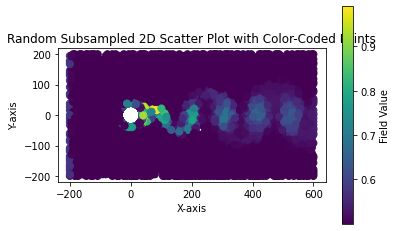

In [421]:
import random
# Define the number of data points you want to plot (e.g., 1000)
num_points_to_select =10000

# Randomly select a subsample of data points
#random_sample_indices = random.sample(range(len(data)), num_points_to_select)
random_sample_indices = random.sample(range(1*22341,2*22341), num_points_to_select)
random_sample = data.iloc[random_sample_indices]

# Extract x, y, and field_value columns from the random subsample
sigmoid = lambda x: 1 / (1 + np.exp(-x))
x = random_sample['x'].astype(np.float32)
y = random_sample['y'].astype(np.float32)
field_value = random_sample['k'].astype(np.float32)
#field_value = np.log1p(sigmoid(field_value))
#field_value = field_value**0.1
field_value = sigmoid(field_value)
#field_value = np.log1p(field_value)
#field_value = np.log1p(sigmoid(field_value))
#field_value = sigmoid(np.log1p(field_value))


#scale the field value
#field_value = np.log(field_value)

# Create a scatter plot with color mapping based on field_value
plt.scatter(x, y, c=field_value, cmap='viridis', marker='o', s=50)

# Add colorbar to show the mapping between values and colors
plt.colorbar(label='Field Value')

# Set labels for the x and y axes
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Optionally, add a title to the plot
plt.title('Random Subsampled 2D Scatter Plot with Color-Coded Points')
# Set equal aspect ratio for the plot
plt.gca().set_aspect('equal', adjustable='box')

# Show the plot
plt.show()

In [422]:
train_data, val_data = train_test_split(random_sample, test_size=0.5, random_state=99)
print(f'length of train dataset: {len(train_data)}           ')

length of train dataset: 5000           


In [423]:
class MyDataset(Dataset):
    def __init__(self, data, features_mean, features_std, labels_mean, labels_std):
        self.features = data[['x', 'y', 't', 'wind', 'leak_x', 'leak_y', 'leak_s']].astype(np.float32)
        self.labels = data[['u', 'v', 'c', 'k', 'w']].astype(np.float32)
        print(f'length of dataset: {len(self.features)}')
        
        # Calculate mean and standard deviation for features and labels
        self.features_mean = features_mean
        self.features_std = features_std
        self.labels_mean = labels_mean
        self.labels_std = labels_std
        
    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        features = self.features.iloc[idx].values
        labels = self.labels.iloc[idx].values
        
        # Normalize features and labels
        epsilon = 1e-8        
        features_normalized = ((features - self.features_mean) / (self.features_std + epsilon)).astype(np.float32)
        labels_normalized = ((labels - self.labels_mean) / (self.labels_std + epsilon)).astype(np.float32)
        
        # Convert to torch.Tensor
        features_tensor = torch.FloatTensor(features_normalized)
        labels_tensor = torch.FloatTensor(labels_normalized)        
        return features_tensor, labels_tensor

In [424]:
# Calculate mean and standard deviation of features and labels based on train_data
features = train_data[['x', 'y', 't', 'wind', 'leak_x', 'leak_y', 'leak_s']].astype(np.float32)
labels = train_data[['u', 'v', 'c', 'k', 'w']].astype(np.float32)
features_mean = np.mean(features, axis=0)
features_std = np.std(features, axis=0)
labels_mean = np.mean(labels, axis=0)
labels_std = np.std(labels, axis=0)
# Generate train and test datasets
dataset = MyDataset(train_data, features_mean, features_std, labels_mean, labels_std)
val_dataset = MyDataset(val_data, features_mean, features_std, labels_mean, labels_std) 
# Generate train and test dataloaders
batch_size = 256
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

length of dataset: 5000
length of dataset: 5000


In [425]:
layers = [7, 20, 20, 20, 20, 20, 20, 20, 20, 5]
model = PhysicsInformedNN(layers, dataset, dataloader, val_dataloader)

In [426]:
# prepare data collection in the training process
train_loss_total = []
train_loss_u = []
train_loss_v = []
train_loss_c = []
train_loss_k = []
train_loss_w = []
train_loss_cont = []
train_loss_conv = []
validation_loss_total = []
validation_loss_u = []
validation_loss_v = []
validation_loss_c = []
validation_loss_k = []
validation_loss_w = []

def collect_train_loss(loss,loss_u,loss_v,loss_c,loss_k,loss_w,loss_cont,loss_conv):
    train_loss_total.append(loss)
    train_loss_u.append(loss_u)
    train_loss_v.append(loss_v)
    train_loss_c.append(loss_c)
    train_loss_k.append(loss_k)
    train_loss_w.append(loss_w)
    train_loss_cont.append(loss_cont)
    train_loss_conv.append(loss_conv)
    
def collect_validation_loss(loss,loss_u,loss_v,loss_c,loss_k,loss_w):
    validation_loss_total.append(loss)
    validation_loss_u.append(loss_u)
    validation_loss_v.append(loss_v)
    validation_loss_c.append(loss_c)
    validation_loss_k.append(loss_k)
    validation_loss_w.append(loss_w)

In [427]:
model.train(250)

/tmp/ipykernel_52717/4264776767.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(batch_features[:, 0:1], requires_grad=True).float().to(device)
/tmp/ipykernel_52717/4264776767.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(batch_features[:, 1:2], requires_grad=True).float().to(device)
/tmp/ipykernel_52717/4264776767.py:117: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(batch_features[:, 2:3], requires_grad=True).float().to(device)
/tmp/ipykernel_52717/4264776767.py:118: UserWa

train_Loss: 2.598e+00, u: 1.19e+00, v: 1.01e+00, c: 3.45e-01, k: 3.42e-02, w: 2.01e-02, cont: 2.72e-05, conv: 4.88e-05


/tmp/ipykernel_52717/4264776767.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val = torch.tensor(batch_features_val[:, 0:1]).float().to(device)
/tmp/ipykernel_52717/4264776767.py:143: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val = torch.tensor(batch_features_val[:, 1:2]).float().to(device)
/tmp/ipykernel_52717/4264776767.py:144: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_val = torch.tensor(batch_features_val[:, 2:3]).float().to(device)
/tmp/ipykernel_52717/4264776767.py:145: UserWarning: To copy construct from a tens

valid_Loss: 2.373e+00, u: 7.34e-01, v: 7.45e-01, c: 1.42e-01, k: 6.67e-01, w: 8.52e-02
Epoch 0: Training Loss = 2.399383544921875, Validation Loss = 3.0296945095062258
train_Loss: 2.128e+00, u: 8.57e-01, v: 9.30e-01, c: 3.02e-01, k: 3.23e-02, w: 5.13e-03, cont: 5.15e-04, conv: 1.45e-04
valid_Loss: 2.259e+00, u: 5.48e-01, v: 5.04e-01, c: 1.85e-01, k: 9.32e-01, w: 8.97e-02
Epoch 1: Training Loss = 1.6090686321258545, Validation Loss = 2.4041097283363344
train_Loss: 1.407e+00, u: 5.48e-01, v: 5.93e-01, c: 2.25e-01, k: 2.55e-02, w: 3.86e-03, cont: 6.32e-03, conv: 5.15e-03
valid_Loss: 2.139e+00, u: 3.92e-01, v: 5.41e-01, c: 2.48e-01, k: 8.99e-01, w: 5.85e-02
Epoch 2: Training Loss = 1.253161072731018, Validation Loss = 2.1915009677410127
train_Loss: 1.292e+00, u: 4.38e-01, v: 6.05e-01, c: 1.96e-01, k: 2.94e-02, w: 4.49e-03, cont: 1.30e-02, conv: 5.88e-03
valid_Loss: 1.862e+00, u: 2.62e-01, v: 3.42e-01, c: 3.20e-01, k: 8.71e-01, w: 6.66e-02
Epoch 3: Training Loss = 0.7983434796333313, Valida

KeyboardInterrupt: 

In [ ]:
print(len(train_loss_u))

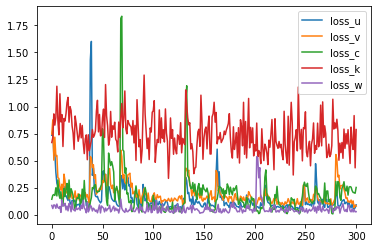

In [432]:
# plt.plot(train_loss_u,label='loss_u')
# plt.plot(train_loss_v,label='loss_v')
# plt.plot(train_loss_c,label='loss_c')
# plt.plot(train_loss_k,label='loss_k')
# plt.plot(train_loss_w,label='loss_w')
# plt.plot(train_loss_cont,label='loss_cont')
# plt.plot(train_loss_conv,label='loss_conv')
plt.plot(validation_loss_u[:-100],label='loss_u')
plt.plot(validation_loss_v[:-100],label='loss_v')
plt.plot(validation_loss_c[:-100],label='loss_c')
plt.plot(validation_loss_k[:-100],label='loss_k')
plt.plot(validation_loss_w[:-100],label='loss_w')
plt.legend()

## Loss weights = 1, Lr=0.001

In [362]:
train_loss_total_3 = train_loss_total
train_loss_u_3 = train_loss_u
train_loss_v_3 =train_loss_v
train_loss_c_3 = train_loss_c
train_loss_k_3 = train_loss_k
train_loss_w_3 = train_loss_w
train_loss_cont_3 = train_loss_cont
train_loss_conv_3 = train_loss_conv
validation_loss_total_3 = validation_loss_total
validation_loss_u_3 = validation_loss_u
validation_loss_v_3 = validation_loss_v
validation_loss_c_3 = validation_loss_c
validation_loss_k_3 = validation_loss_k
validation_loss_w_3 = validation_loss_w

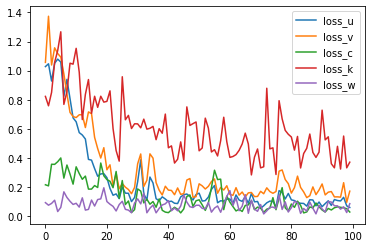

In [363]:
# plt.plot(train_loss_u_2,label='loss_u')
# plt.plot(train_loss_v_2,label='loss_v')
# plt.plot(train_loss_c_2,label='loss_c')
# plt.plot(train_loss_k_2,label='loss_k')
# plt.plot(train_loss_w_2,label='loss_w')
# plt.plot(train_loss_cont_2,label='loss_cont')
# plt.plot(train_loss_conv_2,label='loss_conv')
plt.plot(validation_loss_u_2,label='loss_u')
plt.plot(validation_loss_v_2,label='loss_v')
plt.plot(validation_loss_c_2,label='loss_c')
plt.plot(validation_loss_k_2,label='loss_k')
plt.plot(validation_loss_w_2,label='loss_w')
plt.legend()

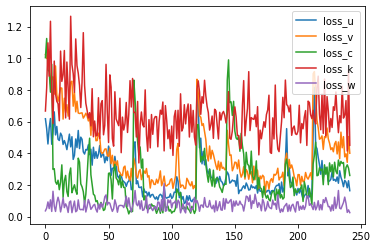

In [334]:
# plt.plot(train_loss_u_1,label='loss_u')
# plt.plot(train_loss_v_1,label='loss_v')
# plt.plot(train_loss_c_1,label='loss_c')
# plt.plot(train_loss_k_1,label='loss_k')
# plt.plot(train_loss_w_1,label='loss_w')
# plt.plot(train_loss_cont_1,label='loss_cont')
# plt.plot(train_loss_conv_1,label='loss_conv')
plt.plot(validation_loss_u_1,label='loss_u')
plt.plot(validation_loss_v_1,label='loss_v')
plt.plot(validation_loss_c_1,label='loss_c')
plt.plot(validation_loss_k_1,label='loss_k')
plt.plot(validation_loss_w_1,label='loss_w')
plt.legend()